In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/rickwierenga/datasets-1", .branch("iris"))' Datasets
%install '.package(url: "https://github.com/s5tf-team/S5TF", .branch("master"))' S5TF

%install-swiftpm-flags -Xcc -isystem/usr/include/freetype2 -Xswiftc -lfreetype
%install '.package(url: "https://github.com/IBM-Swift/BlueCryptor.git", from: "1.0.28")' Cryptor
%install '.package(url: "https://github.com/KarthikRIyer/swiftplot", .branch("master"))' SwiftPlot AGGRenderer

print("\u{001B}[2J") //Removes installation output.

In [2]:
import AGGRenderer
import Datasets
import Foundation
import TensorFlow
import S5TF
import SwiftPlot

In [3]:
//Google Colab doesn't support rich output in Swift at the moment. We will use Python interop as a workaround.
%include "EnableIPythonDisplay.swift"
func display(base64EncodedPNG: String) {
  let displayImage = Python.import("IPython.display")
  let codecs = Python.import("codecs")
  let imageData = codecs.decode(Python.bytes(base64EncodedPNG, encoding: "utf8"), encoding: "base64")
  displayImage.Image(data: imageData, format: "png").display()
}

In [4]:
let hiddenSize: Int = 10
struct IrisModel: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: relu)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

var model = IrisModel()

In [5]:
let optimizer = SGD(for: model, learningRate: 0.01)

In [6]:
var trainAccuracyResults: [Float] = []
var trainLossResults: [Float] = []

In [7]:
func accuracy(predictions: Tensor<Int32>, truths: Tensor<Int32>) -> Float {
    return Tensor<Float>(predictions .== truths).mean().scalarized()
}

for epoch in 1...25 {
    var epochLoss: Float = 0
    var epochAccuracy: Float = 0
    var batchCount: Int = 0
    for batch in Iris.train.batched(32) {
        let (loss, grad) = model.valueWithGradient { (model: IrisModel) -> Tensor<Float> in
            let logits = model(batch.data)
            return softmaxCrossEntropy(logits: logits, labels: batch.labels)
        }
        optimizer.update(&model, along: grad)
        
        let logits = model(batch.data)
        epochAccuracy += accuracy(predictions: logits.argmax(squeezingAxis: 1), truths: batch.labels)
        epochLoss += loss.scalarized()
        batchCount += 1
    }
    epochAccuracy /= Float(batchCount)
    epochLoss /= Float(batchCount)
    trainAccuracyResults.append(epochAccuracy)
    trainLossResults.append(epochLoss)
    print("Epoch \(epoch): Loss: \(epochLoss), Accuracy: \(epochAccuracy)")
}

[----------------------------------------] 100% ETA: 0s          
Epoch 1: Loss: 2.06224, Accuracy: 0.3125
Epoch 2: Loss: 1.2673318, Accuracy: 0.49375
Epoch 3: Loss: 1.0638658, Accuracy: 0.60625
Epoch 4: Loss: 0.9905411, Accuracy: 0.5971591
Epoch 5: Loss: 0.94187546, Accuracy: 0.6039773
Epoch 6: Loss: 0.92186326, Accuracy: 0.6568182
Epoch 7: Loss: 0.90852356, Accuracy: 0.7346591
Epoch 8: Loss: 0.8993784, Accuracy: 0.7534091
Epoch 9: Loss: 0.88833445, Accuracy: 0.7625
Epoch 10: Loss: 0.8811016, Accuracy: 0.7625
Epoch 11: Loss: 0.87130356, Accuracy: 0.73125
Epoch 12: Loss: 0.8642376, Accuracy: 0.775
Epoch 13: Loss: 0.8546728, Accuracy: 0.75
Epoch 14: Loss: 0.84780455, Accuracy: 0.78125
Epoch 15: Loss: 0.8397624, Accuracy: 0.76875
Epoch 16: Loss: 0.8316881, Accuracy: 0.775
Epoch 17: Loss: 0.8241745, Accuracy: 0.775
Epoch 18: Loss: 0.8174964, Accuracy: 0.7875
Epoch 19: Loss: 0.81061393, Accuracy: 0.8
Epoch 20: Loss: 0.80317414, Accuracy: 0.80625
Epoch 21: Loss: 0.79631996, Accuracy: 0.8125

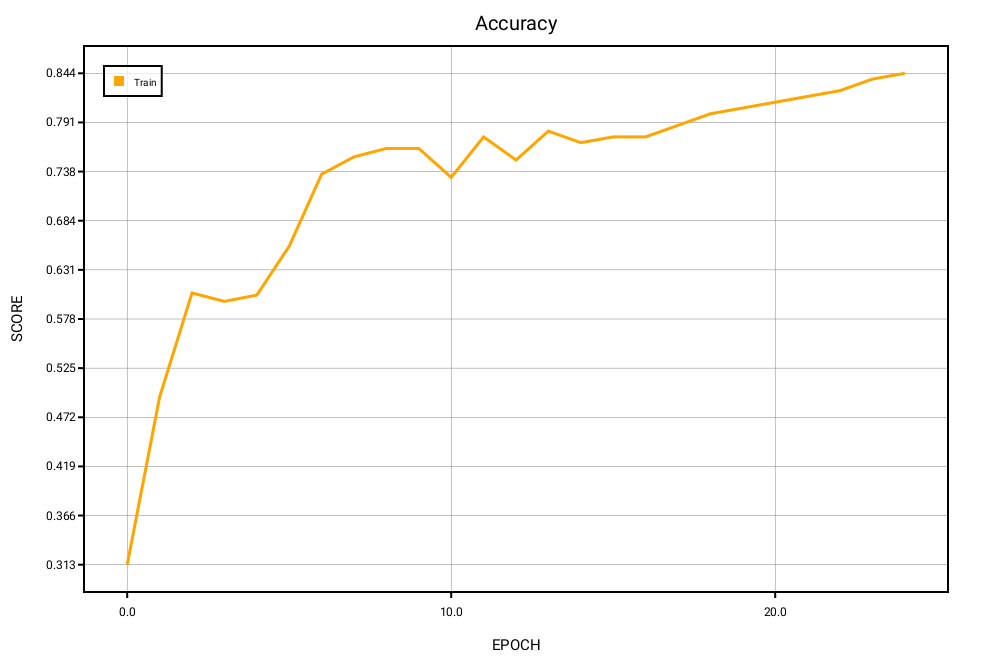

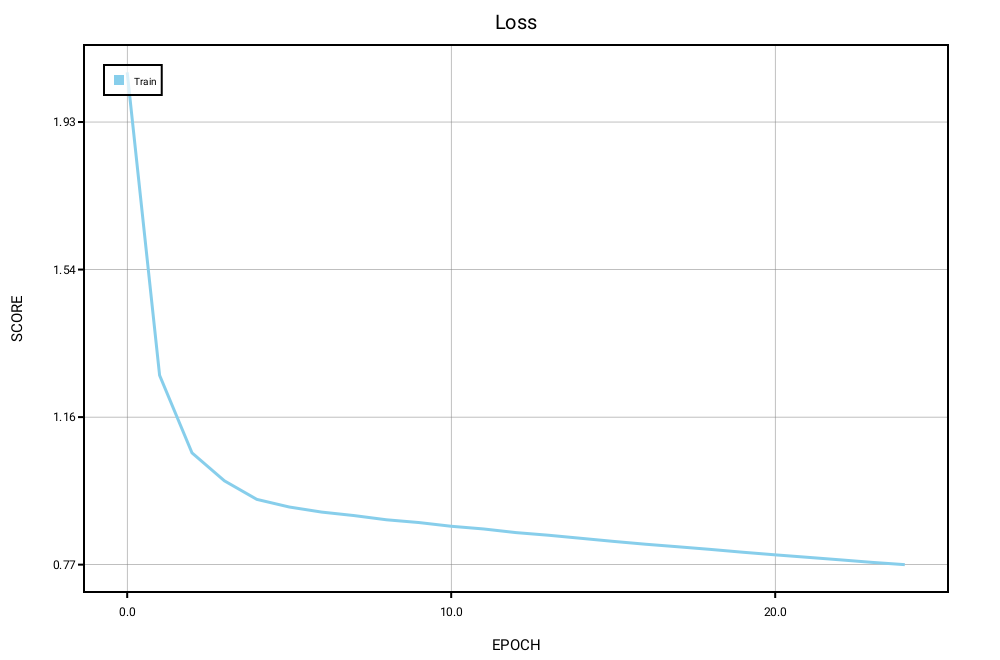

In [8]:
let epochs: [Float] = Array(stride(from: Float(0), to: Float(25), by: Float(1)))

var agg_renderer: AGGRenderer = AGGRenderer()

var accuracyGraph = LineGraph<Float,Float>(enablePrimaryAxisGrid: true)
accuracyGraph.addSeries(epochs, trainAccuracyResults, label: "Train", color: .orange)

accuracyGraph.plotTitle.title = "Accuracy"
accuracyGraph.plotLabel.xLabel = "EPOCH"
accuracyGraph.plotLabel.yLabel = "SCORE"
accuracyGraph.plotLineThickness = 3.0

accuracyGraph.drawGraph(renderer: agg_renderer)
display(base64EncodedPNG: agg_renderer.base64Png())

var lossGraph = LineGraph<Float,Float>(enablePrimaryAxisGrid: true)

lossGraph.addSeries(epochs, trainLossResults, label: "Train", color: .lightBlue)
lossGraph.plotTitle.title = "Loss"
lossGraph.plotLabel.xLabel = "EPOCH"
lossGraph.plotLabel.yLabel = "SCORE"
lossGraph.plotLineThickness = 3.0

lossGraph.drawGraph(renderer: agg_renderer)
display(base64EncodedPNG: agg_renderer.base64Png())